<a href="https://colab.research.google.com/github/sergienko4/deep-learing/blob/main/ex10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning: Ex.10 - RNN

Submitted by: [... **your name and ID** ...]


In [5]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import SimpleRNN, LSTM # <--- recurrent layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
import re
print(tf.__version__)

2.7.0


In [6]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/ex10/war_and_peace.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***
### 1. Preprocess the text corpus

(if you are using google colab, remember to upload the corpus file first..)

In [7]:
# f = open('war_and_peace.txt','r') # open the corpus file
f = open(path,'r') 
text = f.read().lower()  # read file and convert to lower-case letters
data = text.replace('\n',' ')

data = re.sub(r'[^a-zA-Z0-9 ]',r'',data)

print('len(text) = ',len(text))

print(data[:400]) # print the first 400 characters..

len(text) =  3196213
well prince so genoa and lucca are now just family estates of the buonapartes but i warn you if you dont tell me that this means war if you still try to defend the infamies and horrors perpetrated by that antichristi really believe he is antichristi will have nothing more to do with you and you are no longer my friend no longer my faithful slave as you call yourself but how do you do i see i have 


- generate training sequences of `T=20` characters, by sampling the text corpus with a stride of 5 characters (i.e., each sequences starts 5 chars after the begining of the last sequences).

- generate a matching list, holding the `next_char` for each of your sequences.

- how many sequences did you extract in total? `N = ?`

- convert the sequences into a 1-hot representation, suitable for our model trainig:

`X.shape = (N, T, len(chars))`

`Y.shape = (N, len(chars))`

In [8]:
chars = sorted(list(set(data)))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))
print('chars = ',chars)

There are 3083435 total characters and 37 unique characters in your data.
chars =  [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [9]:
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# ix_to_char

In [10]:
T = 20  # extract training sequences of length T
stride = 5

sequences = []  # This holds our extracted sequences
next_chars = []  # This holds the targets (the follow-up character)

for i in range(0, len(data) - T, stride):
    sequences.append(data[i: i + T])
    next_chars.append(data[i + T])

In [11]:
X = np.zeros((len(sequences), T, len(chars)), dtype='bool')
Y = np.zeros((len(sequences), len(chars)), dtype='bool')

for i, seq in enumerate(sequences):
    for t, char in enumerate(seq):
        X[i, t, char_to_ix[char]] = 1
    Y[i, char_to_ix[next_chars[i]]] = 1
    
print('X.shape = (#examples, T, input-dim) =', X.shape)
print('Y.shape = (#examples, output-dim) =', Y.shape)

X.shape = (#examples, T, input-dim) = (616683, 20, 37)
Y.shape = (#examples, output-dim) = (616683, 37)


***
### 2. LTSM Model

- Build an `LTSM` model with 128 (hidden)-units that accepts the input sequences. Add a `Dense` layer on top of it, with `len(chars)` softmax units.

- Train the model for only 1 epoch (use: `RMSprop` and batch size of 128).



In [12]:
model = Sequential(name='LSTM_128')
model.add(Input(shape=(T, len(chars))))  # (12,27)
model.add(LSTM(128)) # 128 internal state units
model.add(Dense(len(chars), activation="softmax"))
model.summary()

Model: "LSTM_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               84992     
                                                                 
 dense (Dense)               (None, 37)                4773      
                                                                 
Total params: 89,765
Trainable params: 89,765
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

history = model.fit(X, Y, epochs=1, batch_size=128)

4818/4818 [==============================] - 25s 4ms/step - loss: 2.0242


### 3. Model predictions


- use the senternce `the meaning of life ` as an input to the model (convert it to 1-hot first..),

- plot the model's output as a probability distribution over the list of chars.

- sample a single char from that distribution, and add it to the generated sentence.

- update the 1-hot buffer, and continue the process for 99 more letters (using a loop).

- print the resulting sentence.

In [14]:
input = 'the meaning of life'

In [15]:
input_one_hot = np.zeros((len(input), T, len(chars)), dtype='bool')

In [16]:
input_one_hot.shape

(19, 20, 37)

In [17]:
y_hat = model.predict(input_one_hot)

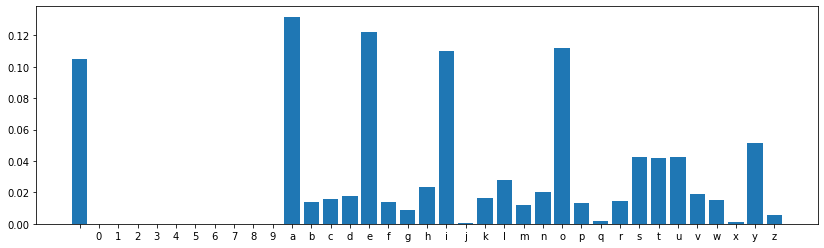

In [18]:
plt.figure(figsize=(14,4))
plt.bar(range(len(chars)), y_hat[0])
plt.xticks(range(len(chars)), labels=chars)
plt.show()

In [19]:
input_buffer = input_one_hot[0]
generated_text = input

yy = []
for i in range(100):
    yhat = model.predict(input_buffer[None,:])
    # sample the next character:
    # ix = np.argmax(yhat)
    ix = np.random.choice(range(len(chars)), p=yhat[0])
    ch = ix_to_char[ix]
    generated_text += ch
    # update the input buffer:
    input_buffer = np.r_[input_buffer[1:,:], np.zeros((1,len(chars)))]
    input_buffer[-1,ix] = 1
    yy.append(yhat)
print(generated_text)

the meaning of lifeicaly of a nemesing peesrouz spribe that byeced sheaw why hived at go he frin dule liagh thay  worta


***
### 3. Fit your model

- Fit your model a bit more (try 10-20 epochs), and regenerate a new `N=100` sentence sample. Does it get any better?

- If you wish, you can try to train the model further, or you can try using a different corpus (dataset) for the training (you can even try a text in hebrew). Be creative ;)

In [20]:
history = model.fit(X, Y, epochs=20, batch_size=128)

Epoch 1/20
4818/4818 [==============================] - 18s 4ms/step - loss: 1.6471
Epoch 2/20
4818/4818 [==============================] - 17s 4ms/step - loss: 1.5177
Epoch 3/20
4818/4818 [==============================] - 20s 4ms/step - loss: 1.4458
Epoch 4/20
4818/4818 [==============================] - 17s 4ms/step - loss: 1.3991
Epoch 5/20
4818/4818 [==============================] - 17s 4ms/step - loss: 1.3648
Epoch 6/20
4818/4818 [==============================] - 18s 4ms/step - loss: 1.3386
Epoch 7/20
4818/4818 [==============================] - 17s 4ms/step - loss: 1.3179
Epoch 8/20
4818/4818 [==============================] - 17s 4ms/step - loss: 1.3006
Epoch 9/20
4818/4818 [==============================] - 17s 4ms/step - loss: 1.2865
Epoch 10/20
4818/4818 [==============================] - 17s 4ms/step - loss: 1.2742
Epoch 11/20
4818/4818 [==============================] - 17s 4ms/step - loss: 1.2634
Epoch 12/20
4818/4818 [==============================] - 17s 4ms/step - lo

In [21]:
input_buffer = input_one_hot[0]
generated_text = input

yy = []
for i in range(100):
    yhat = model.predict(input_buffer[None,:])
    # sample the next character:
    # ix = np.argmax(yhat)
    ix = np.random.choice(range(len(chars)), p=yhat[0])
    ch = ix_to_char[ix]
    generated_text += ch
    # update the input buffer:
    input_buffer = np.r_[input_buffer[1:,:], np.zeros((1,len(chars)))]
    input_buffer[-1,ix] = 1
    yy.append(yhat)
print(generated_text)

the meaning of lifejjxqxapace on the bading of your houseny off he should see him to hapty calm and belonged by his inf


In [22]:
X.shape

(616683, 20, 37)

In [23]:
#---------------------------------------------------freestyle---------------------------------------------------

In [24]:
model_freestyle = Sequential(name='freestyle')
model_freestyle.add(LSTM(
        256,
        input_shape=(X.shape[1], X.shape[2]),
        return_sequences=True
    ))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(LSTM(512, return_sequences=True))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(LSTM(256))
model_freestyle.add(Dense(256))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(Dense(vocab_size))
model_freestyle.add(Activation('softmax'))
model_freestyle.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model_freestyle.summary()


Model: "freestyle"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20, 256)           301056    
                                                                 
 dropout (Dropout)           (None, 20, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 20, 512)           1574912   
                                                                 
 dropout_1 (Dropout)         (None, 20, 512)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               787456    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0 

In [25]:
history = model_freestyle.fit(X, Y, epochs=70, batch_size=1024)

Epoch 1/70
603/603 [==============================] - 43s 65ms/step - loss: 2.3118
Epoch 2/70
603/603 [==============================] - 39s 65ms/step - loss: 1.6868
Epoch 3/70
603/603 [==============================] - 39s 65ms/step - loss: 1.4632
Epoch 4/70
603/603 [==============================] - 39s 65ms/step - loss: 1.3578
Epoch 5/70
603/603 [==============================] - 39s 65ms/step - loss: 1.2951
Epoch 6/70
603/603 [==============================] - 39s 65ms/step - loss: 1.2492
Epoch 7/70
603/603 [==============================] - 39s 65ms/step - loss: 1.2144
Epoch 8/70
603/603 [==============================] - 39s 65ms/step - loss: 1.1852
Epoch 9/70
603/603 [==============================] - 39s 65ms/step - loss: 1.1590
Epoch 10/70
603/603 [==============================] - 39s 65ms/step - loss: 1.1371
Epoch 11/70
603/603 [==============================] - 39s 65ms/step - loss: 1.1155
Epoch 12/70
603/603 [==============================] - 39s 65ms/step - loss: 1.0957
E

In [26]:
input_buffer = input_one_hot[0]
generated_text = input

yy = []
for i in range(100):
    yhat = model.predict(input_buffer[None,:])
    # sample the next character:
    # ix = np.argmax(yhat)
    ix = np.random.choice(range(len(chars)), p=yhat[0])
    ch = ix_to_char[ix]
    generated_text += ch
    # update the input buffer:
    input_buffer = np.r_[input_buffer[1:,:], np.zeros((1,len(chars)))]
    input_buffer[-1,ix] = 1
    yy.append(yhat)
print(generated_text)

the meaning of lifejjxqxwxatiencequely and the sigunier plansorismen looking usseliomaty and hes eurnthing  while to be


In [27]:
path='/content/drive/MyDrive/ex10/russian_troll_tweets_.txt'
# f = open('war_and_peace.txt','r') # open the corpus file
f = open(path,'r') 
text = f.read().lower()  # read file and convert to lower-case letters
data = text.replace('\n','. ')

# data = re.sub(r'[^a-zA-Z0-9 ]',r'',data)

print('len(text) = ',len(text))

print(data[:400]) # print the first 400 characters..

chars = sorted(list(set(data)))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))
print('chars = ',chars)

char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

T = 50  # extract training sequences of length T
stride = 10

sequences = []  # This holds our extracted sequences
next_chars = []  # This holds the targets (the follow-up character)

for i in range(0, len(data) - T, stride):
    sequences.append(data[i: i + T])
    next_chars.append(data[i + T])

X = np.zeros((len(sequences), T, len(chars)), dtype='bool')
Y = np.zeros((len(sequences), len(chars)), dtype='bool')

for i, seq in enumerate(sequences):
    for t, char in enumerate(seq):
        X[i, t, char_to_ix[char]] = 1
    Y[i, char_to_ix[next_chars[i]]] = 1

print('X.shape = (#examples, T, input-dim) =', X.shape)
print('Y.shape = (#examples, output-dim) =', Y.shape)

len(text) =  754765
the question in this election: who can put the plans into action that will make your life better? https://t.co/xreey9oicg. last night, donald trump said not paying taxes was "smart." you know what i call it? unpatriotic. https://t.co/t0xmbfj7zf. couldn't be more proud of @hillaryclinton. her vision and command during last night's debate showed that she's ready to be our next @potus.. if we stand t
There are 763212 total characters and 124 unique characters in your data.
chars =  [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~', '\xa0', '¡', '®', '¿', 'á', 'é', 'í', 'ñ', 'ó', 'ú', 'ĺ', '̶', '\u200a', '\u200b', '–', '—', '‘', '’', '“', '”', '•', '…', '⁰', '→', '✅', '✓', '✔', '❌', '❤', '⬇', '️', '🇸', '🇺', '🌈', '🍕

In [28]:
model_freestyle = Sequential(name='freestyle')
model_freestyle.add(LSTM(
        256,
        input_shape=(X.shape[1], X.shape[2]),
        return_sequences=True
    ))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(LSTM(512, return_sequences=True))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(LSTM(256))
model_freestyle.add(Dense(256))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(Dense(vocab_size))
model_freestyle.add(Activation('softmax'))
model_freestyle.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model_freestyle.summary()

Model: "freestyle"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 256)           390144    
                                                                 
 dropout_3 (Dropout)         (None, 50, 256)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50, 512)           1574912   
                                                                 
 dropout_4 (Dropout)         (None, 50, 512)           0         
                                                                 
 lstm_6 (LSTM)               (None, 256)               787456    
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0 

In [29]:
history = model_freestyle.fit(X, Y, epochs=70, batch_size=1024)

Epoch 1/70
75/75 [==============================] - 15s 154ms/step - loss: 3.4187
Epoch 2/70
75/75 [==============================] - 12s 154ms/step - loss: 3.1628
Epoch 3/70
75/75 [==============================] - 12s 154ms/step - loss: 2.9990
Epoch 4/70
75/75 [==============================] - 12s 154ms/step - loss: 2.6848
Epoch 5/70
75/75 [==============================] - 12s 154ms/step - loss: 2.5110
Epoch 6/70
75/75 [==============================] - 12s 154ms/step - loss: 2.3846
Epoch 7/70
75/75 [==============================] - 12s 154ms/step - loss: 2.3020
Epoch 8/70
75/75 [==============================] - 12s 154ms/step - loss: 2.2089
Epoch 9/70
75/75 [==============================] - 12s 154ms/step - loss: 2.1303
Epoch 10/70
75/75 [==============================] - 12s 154ms/step - loss: 2.0590
Epoch 11/70
75/75 [==============================] - 12s 154ms/step - loss: 2.0052
Epoch 12/70
75/75 [==============================] - 12s 154ms/step - loss: 1.9262
Epoch 13/70
7

In [31]:
input_buffer = input_one_hot[0]
generated_text = input

yy = []
for i in range(100):
    yhat = model.predict(input_buffer[None,:])
    # sample the next character:
    # ix = np.argmax(yhat)
    ix = np.random.choice(range(len(chars)), p=yhat[0])
    ch = ix_to_char[ix]
    generated_text += ch
    # update the input buffer:
    input_buffer = np.r_[input_buffer[1:,:], np.zeros((1,len(chars)))]
    input_buffer[-1,ix] = 1
    yy.append(yhat)
print(generated_text)

ValueError: ignored

***
## Good Luck!